<a href="https://colab.research.google.com/github/pydeoxy/ml-test/blob/main/fin_population_predict_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Population Prediction with ARIMA, Prophet and LSTM**

This example demonstrates Python scripts that compare population forecasts for four Finnish cities: Helsinki, Vantaa, Espoo, and Kauniainen, using three time series models: ARIMA, Prophet and LSTM.

The models predict population trends over the next five years based on historical data from Statistics Finland:
https://pxdata.stat.fi/PxWeb/pxweb/en/StatFin/StatFin__vkour/statfin_vkour_pxt_12bs.px/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess the Excel data
def load_population_data(file_path):
    """
    Load population data from Excel file with specific structure:
    - First row: Header with table name
    - Second row: Years
    - First column: Municipality names
    - Remaining cells: Population values
    """
    # Skip the first row which contains the table name
    # Use the second row as header (years)
    df = pd.read_excel(file_path, skiprows=1, index_col=0)

    # Clean column names (remove any extra spaces or non-numeric characters)
    df.columns = df.columns.astype(str).str.strip()

    # Transpose the dataframe to have years as index and municipalities as columns
    df_transposed = df.T

    # Convert index to datetime (assuming years are in format like '2020')
    df_transposed.index = pd.to_datetime(df_transposed.index, format='%Y')

    # Convert all values to numeric, coercing errors to NaN
    df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')

    return df_transposed

In [3]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Function to forecast using LSTM
def lstm_forecast(series, steps=5, seq_length=3, epochs=100):
    """
    Forecast population using LSTM model
    """
    try:
        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

        # Create sequences
        X, y = create_sequences(scaled_data, seq_length)

        # Reshape data for LSTM [samples, time steps, features]
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Train the model
        model.fit(X, y, batch_size=1, epochs=epochs, verbose=0)

        # Forecast future values
        last_sequence = scaled_data[-seq_length:]
        forecast = []

        for _ in range(steps):
            # Reshape the last sequence for prediction
            X_pred = last_sequence.reshape(1, seq_length, 1)

            # Predict the next value
            pred = model.predict(X_pred, verbose=0)
            forecast.append(pred[0, 0])

            # Update the sequence
            last_sequence = np.append(last_sequence[1:], pred)

        # Inverse transform the forecast
        forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

        return forecast.flatten(), model

    except Exception as e:
        print(f"LSTM Error: {str(e)}")
        return None, None

In [4]:
# Function to forecast using ARIMA
def arima_forecast(series, steps=5, order=(2,1,2)):
    """
    Forecast population using ARIMA model
    """
    try:
        # Fit ARIMA model
        model = ARIMA(series, order=order)
        fitted_model = model.fit()

        # Forecast
        forecast = fitted_model.forecast(steps=steps)

        return forecast, fitted_model

    except Exception as e:
        print(f"ARIMA Error: {str(e)}")
        return None, None

In [5]:
# Function to forecast using Prophet
def prophet_forecast(series, steps=5):
    """
    Forecast population using Prophet model
    """
    try:
        # Prepare data for Prophet
        prophet_df = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })

        # Create and fit Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
        model.fit(prophet_df)

        # Create future dataframe
        future = model.make_future_dataframe(periods=steps, freq='Y')

        # Forecast
        forecast = model.predict(future)

        # Extract the forecasted values
        forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(steps)

        return forecast_values, model

    except Exception as e:
        print(f"Prophet Error: {str(e)}")
        return None, None

In [6]:
# Function to evaluate models
def evaluate_models(actual, arima_forecast, prophet_forecast, lstm_forecast):
    """
    Evaluate model performance using MAE and RMSE
    """
    metrics = {}

    if arima_forecast is not None and len(arima_forecast) == len(actual):
        mae_arima = mean_absolute_error(actual, arima_forecast)
        rmse_arima = np.sqrt(mean_squared_error(actual, arima_forecast))
        metrics['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima}

    if prophet_forecast is not None and len(prophet_forecast) == len(actual):
        mae_prophet = mean_absolute_error(actual, prophet_forecast)
        rmse_prophet = np.sqrt(mean_squared_error(actual, prophet_forecast))
        metrics['Prophet'] = {'MAE': mae_prophet, 'RMSE': rmse_prophet}

    if lstm_forecast is not None and len(lstm_forecast) == len(actual):
        mae_lstm = mean_absolute_error(actual, lstm_forecast)
        rmse_lstm = np.sqrt(mean_squared_error(actual, lstm_forecast))
        metrics['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm}

    return metrics

In [7]:
# Main script
def main(file_path):
    # Load your data
    population_data = load_population_data(file_path)

    # Specify the cities to analyze
    target_cities = ['Helsinki', 'Vantaa', 'Espoo', 'Kauniainen']

    # Check which cities are available in the data
    available_cities = [city for city in target_cities if city in population_data.columns]
    print(f"Available cities: {available_cities}")

    # Forecast for each municipality
    results = {}
    evaluation_results = {}

    for city in available_cities:
        print(f"\nProcessing {city}...")
        series = population_data[city].dropna()

        if len(series) < 10:
            print(f"Not enough data for {city}, skipping...")
            continue

        # Split data into train and test sets (last 5 years for testing)
        train = series.iloc[:-5]
        test = series.iloc[-5:]

        # Forecast with ARIMA
        arima_fc, arima_model = arima_forecast(train, steps=5)

        # Forecast with Prophet
        prophet_fc, prophet_model = prophet_forecast(train, steps=5)

        # Forecast with LSTM
        lstm_fc, lstm_model = lstm_forecast(train, steps=5, seq_length=3, epochs=200)

        # Evaluate models
        if arima_fc is not None and prophet_fc is not None and lstm_fc is not None:
            metrics = evaluate_models(
                test.values,
                arima_fc,
                prophet_fc['yhat'].values if prophet_fc is not None else None,
                lstm_fc
            )
            evaluation_results[city] = metrics

        # Refit models on full data for future forecasting
        full_arima_fc, full_arima_model = arima_forecast(series, steps=5)
        full_prophet_fc, full_prophet_model = prophet_forecast(series, steps=5)
        full_lstm_fc, full_lstm_model = lstm_forecast(series, steps=5, seq_length=3, epochs=200)

        # Store results
        results[city] = {
            'historical': series,
            'test': test,
            'ARIMA': {
                'model': arima_model,
                'forecast_test': arima_fc,
                'forecast_future': full_arima_fc
            },
            'Prophet': {
                'model': prophet_model,
                'forecast_test': prophet_fc,
                'forecast_future': full_prophet_fc
            },
            'LSTM': {
                'model': lstm_model,
                'forecast_test': lstm_fc,
                'forecast_future': full_lstm_fc
            }
        }

    # Create forecast dates
    last_historical_year = population_data.index.max()
    forecast_years = pd.date_range(
        start=last_historical_year + pd.DateOffset(years=1),
        periods=5,
        freq='YS'
    )

    # Generate comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    colors = {
        'ARIMA': 'red',
        'Prophet': 'magenta',
        'LSTM': 'orange'
    }

    for i, city in enumerate(available_cities):
        if city not in results:
            continue

        data = results[city]
        ax = axes[i]

        # Plot historical data
        ax.plot(data['historical'].index, data['historical'].values, 'b-', label='Historical', linewidth=2)

        # Plot test data
        ax.plot(data['test'].index, data['test'].values, 'g-', label='Actual (Test)', linewidth=2)

        # Plot ARIMA forecast
        if data['ARIMA']['forecast_test'] is not None:
            ax.plot(data['test'].index, data['ARIMA']['forecast_test'], '--',
                    color=colors['ARIMA'], label='ARIMA Forecast (Test)', linewidth=2)

        if data['ARIMA']['forecast_future'] is not None:
            ax.plot(forecast_years, data['ARIMA']['forecast_future'], ':',
                    color=colors['ARIMA'], label='ARIMA Forecast (Future)', linewidth=2)

        # Plot Prophet forecast
        if data['Prophet']['forecast_test'] is not None:
            ax.plot(data['test'].index, data['Prophet']['forecast_test']['yhat'].values, '--',
                    color=colors['Prophet'], label='Prophet Forecast (Test)', linewidth=2)
            ax.fill_between(
                data['test'].index,
                data['Prophet']['forecast_test']['yhat_lower'].values,
                data['Prophet']['forecast_test']['yhat_upper'].values,
                color=colors['Prophet'], alpha=0.2
            )

        if data['Prophet']['forecast_future'] is not None:
            ax.plot(forecast_years, data['Prophet']['forecast_future']['yhat'].values, ':',
                    color=colors['Prophet'], label='Prophet Forecast (Future)', linewidth=2)
            ax.fill_between(
                forecast_years,
                data['Prophet']['forecast_future']['yhat_lower'].values,
                data['Prophet']['forecast_future']['yhat_upper'].values,
                color=colors['Prophet'], alpha=0.2
            )

        # Plot LSTM forecast
        if data['LSTM']['forecast_test'] is not None:
            ax.plot(data['test'].index, data['LSTM']['forecast_test'], '--',
                    color=colors['LSTM'], label='LSTM Forecast (Test)', linewidth=2)

        if data['LSTM']['forecast_future'] is not None:
            ax.plot(forecast_years, data['LSTM']['forecast_future'], ':',
                    color=colors['LSTM'], label='LSTM Forecast (Future)', linewidth=2)

        ax.set_title(f'{city} Population Forecast', fontsize=14)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Population', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)

    plt.tight_layout()
    plt.savefig('population_forecast_comparison_three_models.png', dpi=300)
    plt.show()

    # Print evaluation results
    print("\nModel Evaluation Results (Test Set):")
    print("=" * 60)
    for city, metrics in evaluation_results.items():
        print(f"\n{city}:")
        for model, scores in metrics.items():
            print(f"  {model}: MAE = {scores['MAE']:.2f}, RMSE = {scores['RMSE']:.2f}")

    # Create summary table of future forecasts
    summary_data = []
    for city in available_cities:
        if city not in results:
            continue

        data = results[city]
        latest_pop = data['historical'].iloc[-1]

        if data['ARIMA']['forecast_future'] is not None:
            arima_future = data['ARIMA']['forecast_future'].iloc[-1]
            arima_growth = ((arima_future - latest_pop) / latest_pop) * 100
        else:
            arima_future = np.nan
            arima_growth = np.nan

        if data['Prophet']['forecast_future'] is not None:
            prophet_future = data['Prophet']['forecast_future']['yhat'].iloc[-1]
            prophet_growth = ((prophet_future - latest_pop) / latest_pop) * 100
        else:
            prophet_future = np.nan
            prophet_growth = np.nan

        if data['LSTM']['forecast_future'] is not None:
            lstm_future = data['LSTM']['forecast_future'][-1]
            lstm_growth = ((lstm_future - latest_pop) / latest_pop) * 100
        else:
            lstm_future = np.nan
            lstm_growth = np.nan

        summary_data.append({
            'Municipality': city,
            'Latest Population': int(latest_pop),
            'ARIMA Forecast': int(arima_future) if not np.isnan(arima_future) else 'N/A',
            'ARIMA Growth %': f"{arima_growth:.2f}%" if not np.isnan(arima_growth) else 'N/A',
            'Prophet Forecast': int(prophet_future) if not np.isnan(prophet_future) else 'N/A',
            'Prophet Growth %': f"{prophet_growth:.2f}%" if not np.isnan(prophet_growth) else 'N/A',
            'LSTM Forecast': int(lstm_future) if not np.isnan(lstm_future) else 'N/A',
            'LSTM Growth %': f"{lstm_growth:.2f}%" if not np.isnan(lstm_growth) else 'N/A'
        })

    summary_df = pd.DataFrame(summary_data)
    print("\nFuture Forecast Summary (5 Years):")
    print("=" * 100)
    print(summary_df.to_string(index=False))

    # Create a separate plot to compare model performance
    model_names = ['ARIMA', 'Prophet', 'LSTM']
    metrics = ['MAE', 'RMSE']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, city in enumerate(available_cities):
        if city not in evaluation_results:
            continue

        # Prepare data for bar chart
        mae_values = [evaluation_results[city].get(model, {}).get('MAE', 0) for model in model_names]
        rmse_values = [evaluation_results[city].get(model, {}).get('RMSE', 0) for model in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        ax = axes[i]
        rects1 = ax.bar(x - width/2, mae_values, width, label='MAE')
        rects2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

        ax.set_xlabel('Models')
        ax.set_ylabel('Error Value')
        ax.set_title(f'{city} Model Comparison (Lower is Better)')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names)
        ax.legend()

        # Add value labels on bars
        for rect in rects1 + rects2:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('model_performance_comparison.png', dpi=300)
    plt.show()

    # Save detailed results to Excel
    with pd.ExcelWriter('population_forecast_detailed_results_three_models.xlsx') as writer:
        # Save summary
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

        # Save evaluation results
        eval_df = pd.DataFrame.from_dict({(i,j): evaluation_results[i][j]
                                        for i in evaluation_results.keys()
                                        for j in evaluation_results[i].keys()},
                                       orient='index')
        eval_df.to_excel(writer, sheet_name='Evaluation')

        # Save forecasts for each city
        for city in available_cities:
            if city not in results:
                continue

            data = results[city]
            city_df = pd.DataFrame({
                'Year': data['historical'].index,
                'Historical': data['historical'].values
            })

            # Add test period
            test_df = pd.DataFrame({
                'Year': data['test'].index,
                'Actual': data['test'].values
            })

            if data['ARIMA']['forecast_test'] is not None:
                test_df['ARIMA_Forecast'] = data['ARIMA']['forecast_test'].values

            if data['Prophet']['forecast_test'] is not None:
                test_df['Prophet_Forecast'] = data['Prophet']['forecast_test']['yhat'].values
                test_df['Prophet_Lower'] = data['Prophet']['forecast_test']['yhat_lower'].values
                test_df['Prophet_Upper'] = data['Prophet']['forecast_test']['yhat_upper'].values

            if data['LSTM']['forecast_test'] is not None:
                test_df['LSTM_Forecast'] = data['LSTM']['forecast_test']

            # Add future forecasts
            future_df = pd.DataFrame({
                'Year': forecast_years
            })

            if data['ARIMA']['forecast_future'] is not None:
                future_df['ARIMA_Forecast'] = data['ARIMA']['forecast_future'].values

            if data['Prophet']['forecast_future'] is not None:
                future_df['Prophet_Forecast'] = data['Prophet']['forecast_future']['yhat'].values
                future_df['Prophet_Lower'] = data['Prophet']['forecast_future']['yhat_lower'].values
                future_df['Prophet_Upper'] = data['Prophet']['forecast_future']['yhat_upper'].values

            if data['LSTM']['forecast_future'] is not None:
                future_df['LSTM_Forecast'] = data['LSTM']['forecast_future']

            # Combine all data
            combined_df = pd.concat([city_df, test_df, future_df], ignore_index=True)
            combined_df.to_excel(writer, sheet_name=city[:31], index=False)  # Sheet name max 31 chars

Available cities: ['Helsinki', 'Vantaa', 'Espoo', 'Kauniainen']

Processing Helsinki...


INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/ia8asa2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/z0bs69p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70182', 'data', 'file=/tmp/tmp02vk6jdm/ia8asa2n.json', 'init=/tmp/tmp02vk6jdm/z0bs69p0.json', 'output', 'file=/tmp/tmp02vk6jdm/prophet_model0wmme3ad/prophet_model-20250921105257.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/jhauyw91.json
DEBUG:cmdstanpy:input tempfil


Processing Vantaa...


INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/uev5yps_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/4r0dczbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35158', 'data', 'file=/tmp/tmp02vk6jdm/uev5yps_.json', 'init=/tmp/tmp02vk6jdm/4r0dczbv.json', 'output', 'file=/tmp/tmp02vk6jdm/prophet_model9lujctty/prophet_model-20250921105401.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:54:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/8bur6ylf.json
DEBUG:cmdstanpy:input tempfil


Processing Espoo...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/mgu03pzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1960', 'data', 'file=/tmp/tmp02vk6jdm/l83bbmca.json', 'init=/tmp/tmp02vk6jdm/mgu03pzb.json', 'output', 'file=/tmp/tmp02vk6jdm/prophet_modeltwlrdnim/prophet_model-20250921105506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:55:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/yp48c7jn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/62kpym_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: [


Processing Kauniainen...


10:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/s62__7h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02vk6jdm/7wq_aj3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76709', 'data', 'file=/tmp/tmp02vk6jdm/s62__7h3.json', 'init=/tmp/tmp02vk6jdm/7wq_aj3f.json', 'output', 'file=/tmp/tmp02vk6jdm/prophet_modelnzwosjr0/prophet_model-20250921105634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


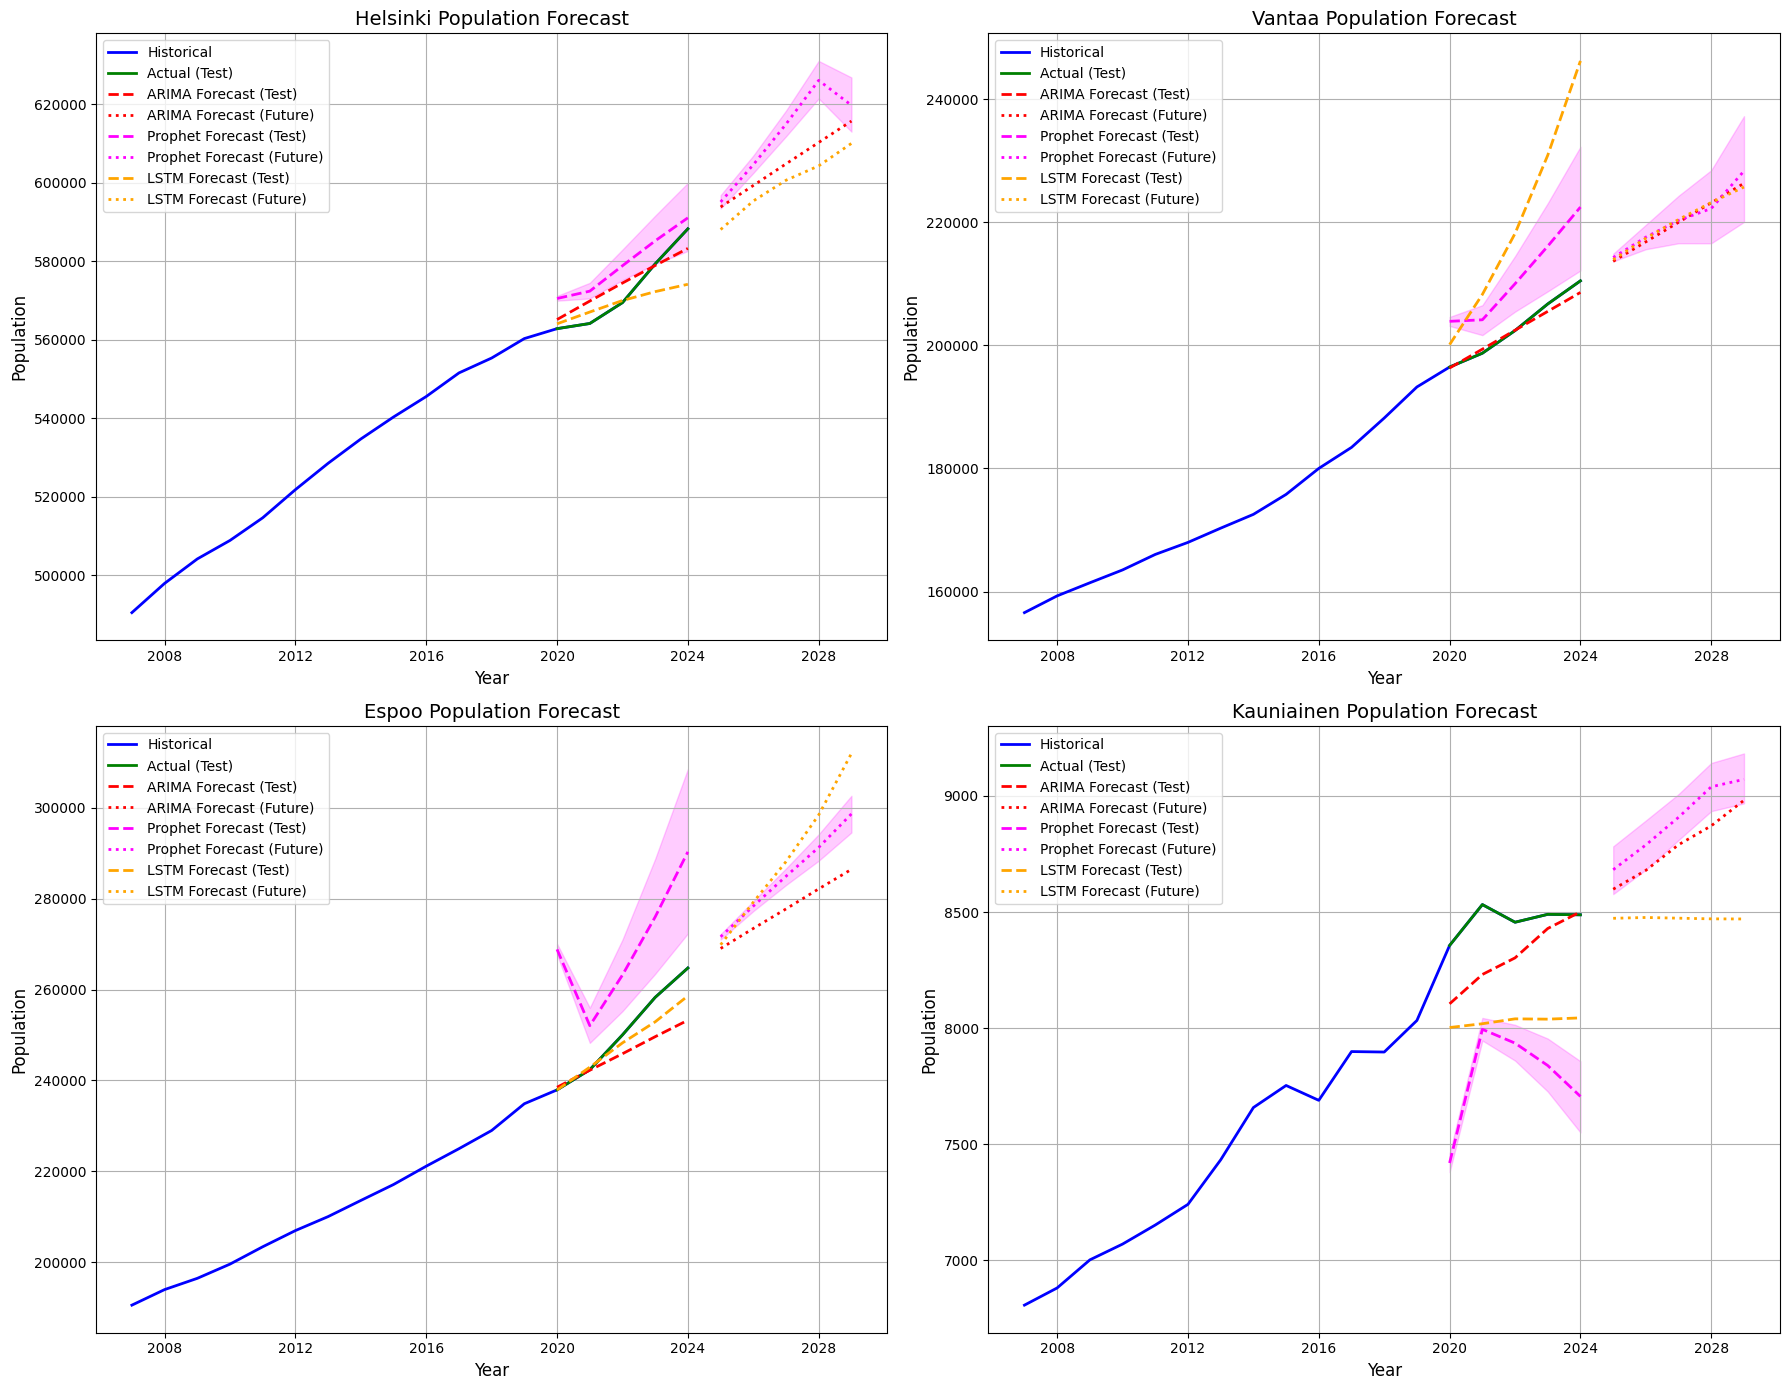


Model Evaluation Results (Test Set):

Helsinki:
  ARIMA: MAE = 3683.72, RMSE = 4195.58
  Prophet: MAE = 6799.61, RMSE = 7178.19
  LSTM: MAE = 5176.74, RMSE = 7210.92

Vantaa:
  ARIMA: MAE = 791.15, RMSE = 1044.77
  Prophet: MAE = 8366.30, RMSE = 8650.81
  LSTM: MAE = 17772.68, RMSE = 21042.61

Espoo:
  ARIMA: MAE = 4999.93, RMSE = 6705.54
  Prophet: MAE = 19423.17, RMSE = 20943.60
  LSTM: MAE = 2775.18, RMSE = 3748.24

Kauniainen:
  ARIMA: MAE = 155.91, RMSE = 190.41
  Prophet: MAE = 685.61, RMSE = 703.31
  LSTM: MAE = 435.62, RMSE = 438.70

Future Forecast Summary (5 Years):
Municipality  Latest Population  ARIMA Forecast ARIMA Growth %  Prophet Forecast Prophet Growth %  LSTM Forecast LSTM Growth %
    Helsinki             588243          615698          4.67%            619722            5.35%         610011         3.70%
      Vantaa             210489          226343          7.53%            228343            8.48%         225732         7.24%
       Espoo             264761    

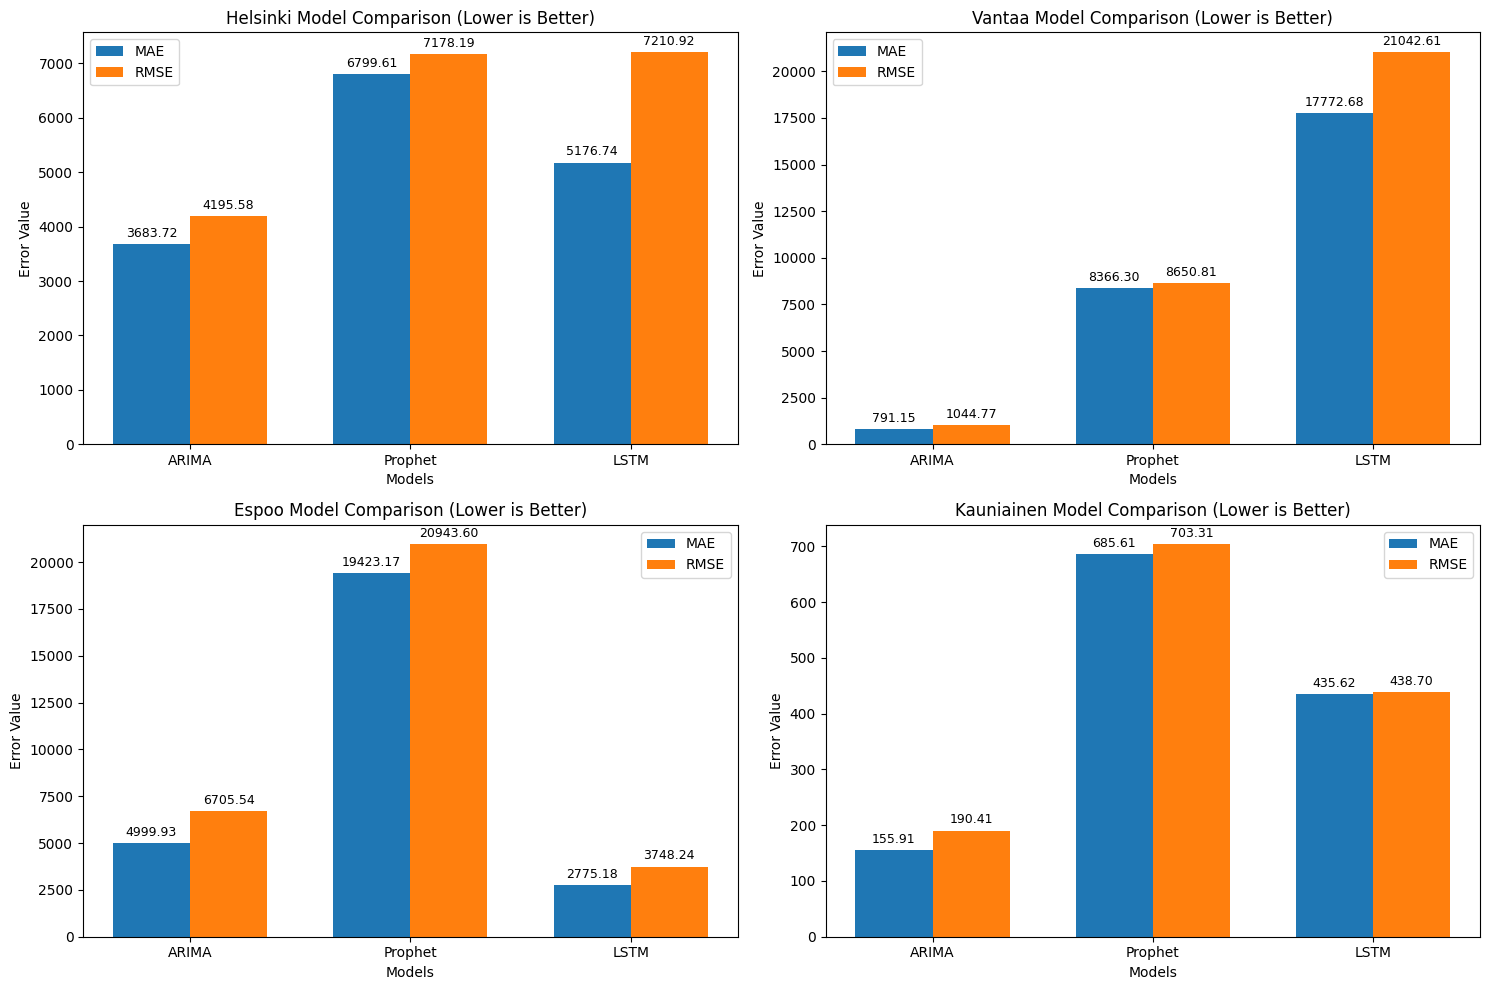

In [8]:
file_path = 'fin_population_2007_2024.xlsx'
main(file_path)